In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Hyperparameters
batch_size = 128
latent_dim = 2        # Use 2 for latent space visualization
epochs = 20
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform: Normalize to [0,1]
transform = transforms.ToTensor()

# Load dataset
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.88MB/s]


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [ ]:
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.view(-1, 28*28).to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 290.9911
Epoch [2/20], Loss: 272.7688
Epoch [3/20], Loss: 269.7073
Epoch [4/20], Loss: 267.8152
Epoch [5/20], Loss: 266.4863
Epoch [6/20], Loss: 265.5137
Epoch [7/20], Loss: 264.8864
Epoch [8/20], Loss: 264.3114
Epoch [9/20], Loss: 263.8173
Epoch [10/20], Loss: 263.4130
Epoch [11/20], Loss: 263.1166
Epoch [12/20], Loss: 262.7078
Epoch [13/20], Loss: 262.4537
Epoch [14/20], Loss: 262.1937
Epoch [15/20], Loss: 261.9985
Epoch [16/20], Loss: 261.8390
Epoch [17/20], Loss: 261.5938
Epoch [18/20], Loss: 261.3865
Epoch [19/20], Loss: 261.2334
Epoch [20/20], Loss: 261.0383


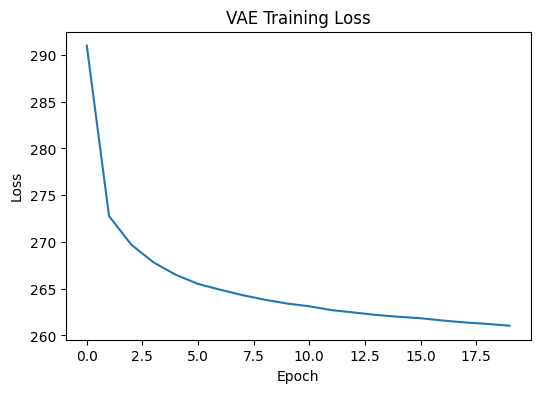

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()


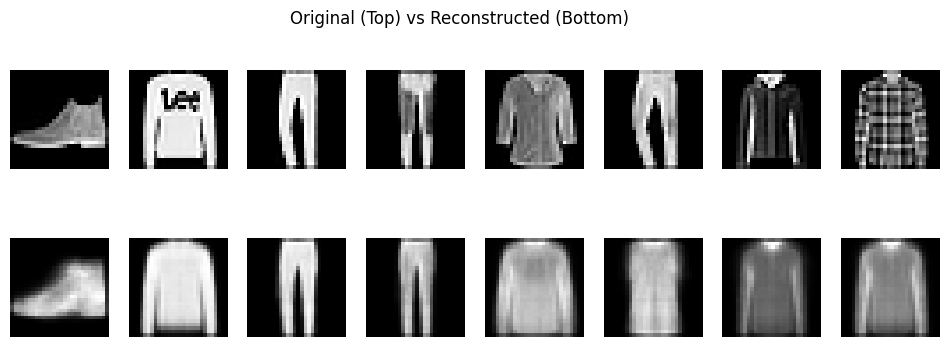

In [ ]:
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.view(-1, 28*28).to(device)
    recon_images, _, _ = model(images)

# Plot original vs reconstructed
n = 8
plt.figure(figsize=(12,4))

for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(images[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i+1+n)
    plt.imshow(recon_images[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
plt.show()


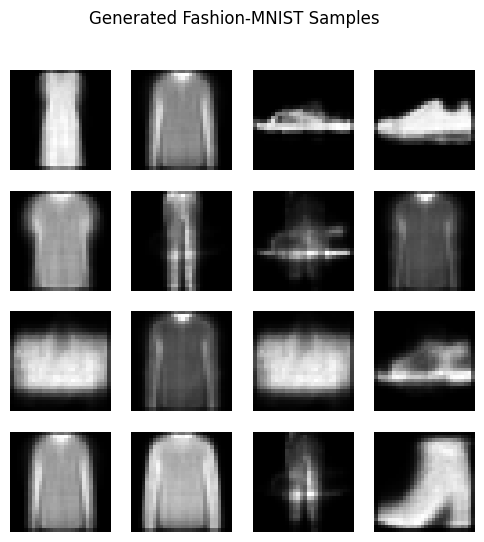

In [ ]:
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = model.decode(z)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

plt.suptitle("Generated Fashion-MNIST Samples")
plt.show()


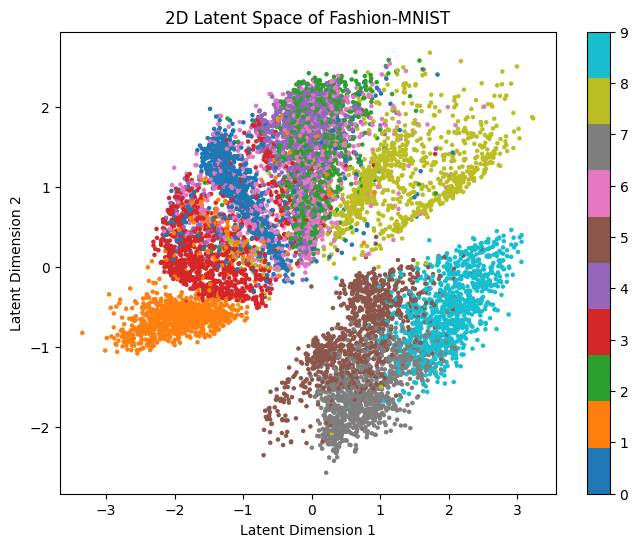

In [ ]:
model.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        mu, _ = model.encode(images)
        latent_vectors.append(mu.cpu())
        labels_list.append(labels)

latent_vectors = torch.cat(latent_vectors)
labels_list = torch.cat(labels_list)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    latent_vectors[:,0],
    latent_vectors[:,1],
    c=labels_list,
    cmap='tab10',
    s=5
)
plt.colorbar(scatter)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space of Fashion-MNIST")
plt.show()
